# Import Library 

In [1]:
# Run this if you start using this notebook for the first time
#import sys
#from os import getcwd, mkdir
#!{sys.executable} -m pip install -r "../../requirements.txt"

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
import scipy.ndimage as sciim
from scipy.signal import savgol_filter
from os.path import abspath
from time import time
from ctypes import *
print(abspath(""))
IMG_DIRPATH = "../../img/"
SO_DIRPATH = "../libs/"

/home/adityap/Documents/Handwritting - Detection/HandWritting-Digit-Detection/src/JupyterNotebook


# Load  C Shared Library 

In [55]:
class Image(Structure):
  _fields_ = [
    ("img", c_void_p), 
    ("nx", c_int), 
    ("ny", c_int), 
  ]
class Position(Structure):
   _fields_ = [
     ("x", c_uint32), 
     ("y", c_uint32), 
   ]
class Data(Structure):
  _fields_ = [
    ("object", POINTER(POINTER(POINTER(Position)))), 
    ("length", c_int)
  ]

SO_FILE_BBOX = abspath("../libs/libbbox.so")
bbox_c = CDLL(SO_FILE_BBOX)
bbox_c.python_bbox_find.argtypes = [np.ctypeslib.ndpointer(dtype=c_ubyte, flags="C_CONTIGUOUS"), c_int, c_int]
bbox_c.python_bbox_find.restype = POINTER(Data)

In [81]:
def serializeArray(pixels, nx, ny):
    total_pixels = nx * ny
    x = [0 for i in range(total_pixels)]
    for i in range(total_pixels):
        x[i] = pixels[i // nx][i % nx]
  
    return np.array(x, dtype=np.ubyte)

def bbox_pipeline(img : np.ndarray):
    shape = np.shape(img)
    if not isinstance(img, np.ndarray): 
        raise TypeError("Image must be a ndarray, get {}".format(type(img).__name__))
    assert (len(shape) == 2), "Image must be a grayscale image. Pixels matrix must have only two dimensions"
  
    ny, nx = shape
    pixels_serialize = serializeArray(img, nx, ny)
  
    try:
        data_ptr = bbox_c.python_bbox_find(pixels_serialize, nx, ny)
    except Exception as e:
        print("Exception occured: {}".format(e))
        print("If error caused by undefined bbox. Make sure to load bbox library first before running this function\n")
        print("Make sure to defined the restype and argtype of bbox_python_find")
        exit(-1)
  
    
    data : Data = data_ptr.contents
    arr_of_arr_of_pos_ptr = data.object
    arr_length = data.length
    objs = []
  
    for i in range(arr_length):
        arr_of_pos_ptr = arr_of_arr_of_pos_ptr[i]
        pos_min = arr_of_pos_ptr[0].contents
        pos_max = arr_of_pos_ptr[1].contents
    
        objs.append([[pos_min.y, pos_min.x], [pos_max.y, pos_max.x]])
    #print(objs)
    #result = BoundingBox.createBoudingBox(img, objs)
    #showPicture(result, False)
    #plt.show()

# Plotting Utility Function

In [5]:
def showPicture(pixels, isRGB, caption=""):
    if isRGB:
        fig = plt.figure()
        plt.axis("off")
        img_RGB = cv2.cvtColor(pixels, cv2.COLOR_BGR2RGB)
        plt.title(caption)
        plt.imshow(img_RGB)
        plt.show()
    else:
        fig = plt.figure()
        plt.axis("off")
        plt.title(caption)
        plt.imshow(pixels, cmap='gray', vmin=0, vmax=255)
        plt.show()
        
    

# Shadow Removal Class

In [6]:
class ShadowRemoval():
  def __init__(self, img):
    self.img = img
    self.kernel = np.ones((7, 7), np.uint8)
    self.output = None

  def backgroudRemoval(self):
    fgbg = cv2.bgsegm.createBackgroundSubtractorMOG() 
    self.output = fgbg.apply(self.img.pixels)

  def remove(self, iterations=1):
    rgb_planes = cv2.split(self.img.pixels)
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((11,11), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)
    shadowremov = cv2.merge(result_norm_planes)
    self.output = shadowremov
    
    

  def update(self):
    self.img.pixels = self.output

# Image Class

In [7]:
class Image():
    def __init__(self, filename) -> None:
        self.pixels = cv2.imread(filename)
        self.backup = None

    def toGrayscale(self):
      self.pixels = cv2.cvtColor(self.pixels, cv2.COLOR_BGR2GRAY)
      
    def invertColor(self, thresh):
      min = 0
      max = thresh
      ny, nx = np.shape(self.pixels)
      for i in range(ny):
        for j in range(nx):
          if min <= self.pixels[i][j] <= max:
            self.pixels[i][j] = 255
          else:
            self.pixels[i][j] = 0

    def accentPicture(self, iterations=1):
      self.pixels = cv2.erode(self.pixels, np.ones((7,7), np.uint8), iterations=iterations)

    def doBackup(self):
      self.backup = np.copy(self.pixels)

    def restart(self):
      self.pixels = np.copy(self.backup)

    def show(self, txt):
        fig = plt.figure()
        plt.axis("off")
        fig.text(.5, 0.12, txt, ha = 'center')
        plt.imshow(self.pixels, cmap = 'gray')
        plt.show()


# Bounding Box Class
Bounding box to detect shape in images

In [8]:
class Node():
    def __init__(self, id : int, pos : list[list[int]]):
        self.root = None
        self.id   = id
        self.pos  = pos
  
    def getRoot(self) -> "Node":
        node = self
        while (node.root != None):
            node = node.root
      
        return node
  
    def getID(self) -> int:
        return self.getRoot().id
      
    def __eq__(self, __o: object) -> bool:
        # would run in O(N_OBJ) time
        if type(self) == type(__o):
            return self.getID() == __o.getID()
    
        else:
            return False
  
    def updateValue(self, new_value : list[int], fnc) -> None:
        root = self.getRoot()
        fnc(root.pos, new_value)
    
    @classmethod
    def resolvedNodeConflict(cls, roots: list["Node"], resolve_fnc) -> None:
        # nodes will have max length of 4, and getRoot would need log(N_OBJ)
        # therefore will run in log(N_OBJ) time
        newRootVal = resolve_fnc(roots)
        newID = roots[0].id
        newRoot = cls(newID, newRootVal)
    
        for root in roots:
            root.root = newRoot
            root.pos = None
    
        return newID

In [78]:
class BoundingBox():
    def __init__(self, pixels):
        self.img = pixels
        self.objects = [] # list of shape
        self.result = np.copy(pixels)
        
    def find(self):
        # search object
        self.__searchObjects()
    
    def resolveFunc(self, roots):
      ref = roots[0].pos
      for i in range(1, len(roots)):
        self.updateFunc(ref, roots[i].pos)
      
      return ref
  
    def updateFunc(self, obj, new_loc : list[list[object]]):
      # In place change the object data
      if len(new_loc) == 1:
          new_loc_i1, new_loc_j1 = new_loc[0]
          new_loc_i2 = new_loc_i1
          new_loc_j2 = new_loc_j1
      else:
          [new_loc_i1, new_loc_j1], [new_loc_i2, new_loc_j2] = new_loc
          
      [min_i, min_j], [max_i, max_j] = obj
      
      obj[0][0] = min(new_loc_i1, min_i)
      obj[0][1] = min(new_loc_j1, min_j)
      obj[1][0] = max(new_loc_i2, max_i)
      obj[1][1] = max(new_loc_j2, max_j)
                
    def __updateObject(self, member_id : int, *new_loc : tuple[int]):
        obj_node : Node = self.objects[member_id - 1]
        obj_node.updateValue([new_loc], self.updateFunc)
                   
    def __resolvedConflict(self, roots : list[Node]):
      return Node.resolvedNodeConflict(roots, self.resolveFunc)
        
    def __createObject(self, *location):
        location = list(location)
        new_node = Node(len(self.objects) + 1, [location, location[:]])
        self.objects.append(new_node)
        return new_node.id
    
    def __searchObjects(self):
        n_i, n_j = np.shape(self.img)
        # upper stram and box consist of member_id of each pixels. Member_id indicate which object this pixels belong to
        # upper_stream holds data for all pixels on the upper side of current pixel
        # box holds data for pixel on the left of current pixel
        # the smallest id is 1, 0 -> no member
        upper_stream = [0 for i in range(n_j)]
        box = 0
        # scan each pixels, going from upper left to lower right
        for i in range(n_i):
          for j in range(n_j):  
            if self.img[i][j] == 0: 
              if box != 0:
                upper_stream[j - 1] = box
                box = 0
              continue
            # because going from upper left to lower right, only need to check pixel from upper and left
            conflict = False
            dict = {box : True} if box != 0 else {}
 
            # check upper if exist
            if i - 1 >= 0:
              for k in range(j - 1, j + 2):
                if k < n_j and self.img[i - 1][k] != 0:
                    if dict.get(upper_stream[k], False) == True:
                      continue
                    if len(dict) == 0:
                      dict[upper_stream[k]] = True
                    
                    # Check for conflict
                    elif len(dict) == 1:
                      roots = []
                      id1 = list(dict.keys())[0]
                      id2 = upper_stream[k]
                      
                      root1 = self.objects[id1 - 1].getRoot()
                      root2 = self.objects[id2 - 1].getRoot()
                      if (root1 != root2):
                        conflict = True
                        roots.append(root1)
                        roots.append(root2)
                        dict[upper_stream[k]] = True
                    
                    elif len(dict) > 1:
                      id3 = upper_stream[k]
                      root3 = self.objects[id3 - 1].getRoot()
                      for root in roots:
                        if (root != root3):
                          roots.append(root3)
                          dict[upper_stream[k]] = True

            if len(dict) == 0:
                # create new object
                member_id = self.__createObject(i, j)
            else:  
              if not conflict:
                  # determine member id
                  member_id = list(dict.keys())[0]
                  # update object
                  self.__updateObject(member_id, i, j)
              else:
                  # resolved conflict, connected object can't have more than one member_id
                  member_id = self.__resolvedConflict(roots)

            # update upper stream value and box
            if box == 0:
                box = member_id

            elif box != 0:
                upper_stream[j - 1] = box
                box = member_id
    
    def getObjects(self):
        dict = {}
        for i in range(len(self.objects)):
            root = self.objects[i].getRoot()
            if dict.get(root.id, None) != None:
                continue
            dict[root.id] = root.pos
        objs = list(dict.values())
        return objs
    
    def viewBbox(self):
        self.__createBoudingBox()
        
    @staticmethod
    def createBoudingBox(img, shapes):
        result = np.copy(img)
        
        for shape in shapes:
            [min_i, min_j], [max_i, max_j] = shape
          
            for i in range(min_i, max_i + 1):
                result[i][min_j] = 255
                result[i][max_j] = 255
          
            for j in range(min_j, max_j + 1):
                result[min_i][j] = 255
                result[max_i][j] = 255
          
        return result

# Helper Function

In [10]:
def shiftImage(img, shift):
    return sciim.shift(img, shift)

def scaleImage(img, show):
    dim = (28, 28)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    if show:
        showPicture(resized, False, "After Scaling")
    return resized

def centerImage(img):
    # create an image with 1 : 1 aspect ratio
    ny, nx = np.shape(img)
    dim = max(nx, ny)
    a = np.zeros((dim, dim))
    for i in range(ny):
        for j in range(nx):
            a[i][j] = img[i][j]
    
    # shift image so the shape in the center
    dx = (dim - nx) / 2
    dy = (dim - ny) / 2
    return shiftImage(a, (dy, dx))

def getShape(x, obj, show=False):
    [min_i, min_j], [max_i, max_j] = obj
    py = (max_i - min_i) + 1
    px = (max_j - min_j) + 1
    
    shape = np.zeros((py, px))
    
    start_i = min_i
    start_j = min_j
    
    for i in range(py):
        for j in range(px):
            shape[i][j] = x[start_i + i][start_j + j]
    if show:
        showPicture(shape, False, "Before Scaling")
    return scaleImage(centerImage(shape), show)

def getPartitions(objs):
    partitions = []
    objs.sort(key = lambda x:x[0][0]) # sort based on min_i value
    upper = objs[0][1][0]
    lower = objs[0][0][0]
    start = 0
    for i in range(1, len(objs)):
        if objs[i][0][0] < upper:
            upper = objs[i][1][0]
            continue
        
        lower, upper = objs[i][0][0], objs[i][1][0]
        partitions.append(objs[start: i])
        start = i
        
    return partitions
    
def sortObjs(objs):
    partitions = getPartitions(objs)
    sortedObjs = []
    for partition in partitions:
        partition.sort(key = lambda x: x[0][1]) # sort based on min j
        for obj in partition:
            sortedObjs.append(obj)
            
    return sortedObjs

# Image preprocess
1. Remove Shadow

---


2. Convert to grayscale

---


3. Invert color (background will be black __(0)__ text will be white __(255)__)

In [11]:
FILENAME = "301914.jpg"
try:
    mkdir(abspath("../../out/{}".format(FILENAME)))
except:
    pass

In [12]:
try:
     mkdir(abspath("../../out/{}/detected_shapes".format(FILENAME)))
except:
    pass

In [13]:
IMG_FILEPATH = IMG_DIRPATH + FILENAME

In [14]:
# load image
img2 = Image(IMG_FILEPATH)
img2.toGrayscale()

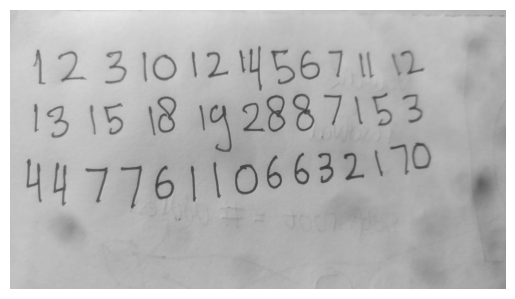

In [15]:
showPicture(img2.pixels, True)

In [16]:
shr2 = ShadowRemoval(img2)
shr2.remove()

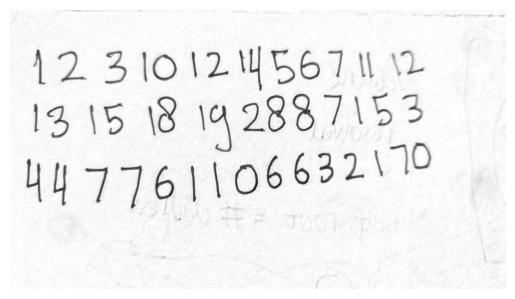

In [17]:
showPicture(shr2.output, True)

Hasil shadow removal

In [18]:
shr2.update()
#img2.accentPicture()

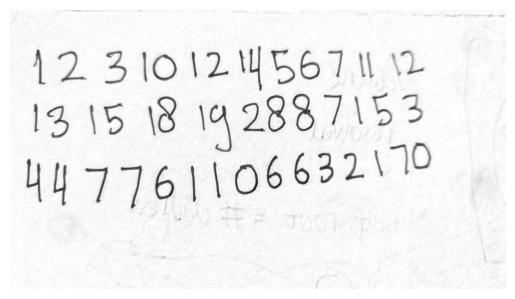

In [19]:
showPicture(img2.pixels, True)

# Image pixels density graph

In [20]:
import seaborn as sns
def plotDensity(img):
  x = img2.pixels.reshape(1, -1)[0]
  sns.set_style('whitegrid')
  plt.xlim(0, 255)
  X, Y = sns.kdeplot(x, bw=0.5, gridsize=500).get_lines()[0].get_data()
  return X, Y

/home/adityap/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


(array([-4.80687341e+01, -4.73650518e+01, -4.66613695e+01, -4.59576872e+01,
        -4.52540049e+01, -4.45503226e+01, -4.38466403e+01, -4.31429580e+01,
        -4.24392757e+01, -4.17355934e+01, -4.10319111e+01, -4.03282288e+01,
        -3.96245465e+01, -3.89208642e+01, -3.82171819e+01, -3.75134996e+01,
        -3.68098173e+01, -3.61061350e+01, -3.54024527e+01, -3.46987704e+01,
        -3.39950881e+01, -3.32914058e+01, -3.25877235e+01, -3.18840412e+01,
        -3.11803589e+01, -3.04766766e+01, -2.97729943e+01, -2.90693120e+01,
        -2.83656297e+01, -2.76619474e+01, -2.69582651e+01, -2.62545828e+01,
        -2.55509005e+01, -2.48472182e+01, -2.41435359e+01, -2.34398536e+01,
        -2.27361713e+01, -2.20324890e+01, -2.13288067e+01, -2.06251244e+01,
        -1.99214421e+01, -1.92177598e+01, -1.85140775e+01, -1.78103952e+01,
        -1.71067129e+01, -1.64030306e+01, -1.56993483e+01, -1.49956660e+01,
        -1.42919837e+01, -1.35883014e+01, -1.28846191e+01, -1.21809368e+01,
        -1.1

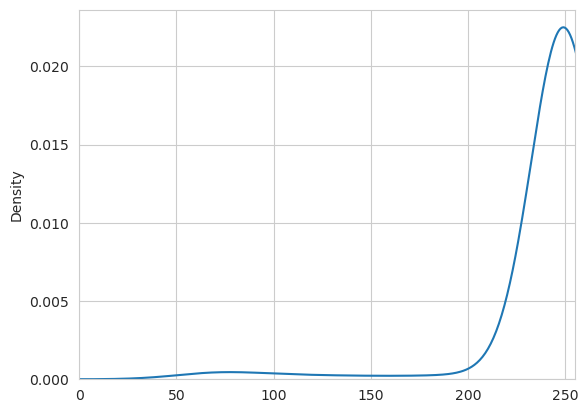

In [21]:
plotDensity(img2.pixels)

# Image Thresholding

In [22]:
def fromPixelsToHistogram(img):
    id = np.array([i for i in range(0, 256)])
    x = np.array([0 for i in range(0, 256)])
    Y = img.pixels.reshape(1, -1)[0] # change matrix into an array

    for pix_val in Y:
      x[pix_val] += 1     
    window = 21
    order = 2

    x_smoothen = savgol_filter(x, window, order)
    x_smoothen[x_smoothen<0] = 0
    x_smoothen /= len(Y)
    return np.round(x_smoothen, 5)

def findPeak(x):
  # just find the maximum value between 0 - 200
  peak = [0, 0]
  for i in range(200):
    if peak[1] < x[i]:
      peak = [i, x[i]]

  return peak

def fromPeakToThreshold(X, realPeak, max_dist_percentage=0.1):
    def findValley():
      valley = 1
      for i in range(realPeak[0], 201):
        valley = min(valley, X[i])
      
      digit = 0
      mult = 1
      temp = valley * 1
      while temp < 1:
        temp *= 10
        mult *= 10
        digit += 1

      return valley, mult, digit
    
    i = realPeak[0]
    valley, mult, digit = findValley()

    thresh = 200 # if not found any valley, therefore always monotonic decrease, then the thresh value would be the biggest possible pixel value
    thresh_val = round(valley + (1 / mult), digit)
    for i in range(i + 1, 201):
      print(i, X[i])
      if X[i - 1] > X[i] and X[i + 1] > X[i]:

        if X[i] <= thresh_val:
          thresh = i

      last_value = X[i]
      i += 1
      

    return thresh

In [23]:
X = fromPixelsToHistogram(img2)

In [24]:
peak = findPeak(X)

In [25]:
peak

[70, 0.00062]

In [26]:
thresh = fromPeakToThreshold(X, peak)

71 0.00055
72 0.00062
73 0.00055
74 0.00061
75 0.00053
76 0.0006
77 0.00051
78 0.00058
79 0.00049
80 0.00055
81 0.00047
82 0.00053
83 0.00045
84 0.00051
85 0.00044
86 0.0005
87 0.00042
88 0.00048
89 0.00041
90 0.00046
91 0.00039
92 0.00045
93 0.00038
94 0.00043
95 0.00036
96 0.00041
97 0.00035
98 0.0004
99 0.00033
100 0.00038
101 0.00032
102 0.00036
103 0.00031
104 0.00035
105 0.0003
106 0.00034
107 0.00028
108 0.00032
109 0.00027
110 0.00031
111 0.00027
112 0.00031
113 0.00026
114 0.0003
115 0.00025
116 0.00029
117 0.00025
118 0.00026
119 0.00026
120 0.00026
121 0.00026
122 0.00027
123 0.00027
124 0.00028
125 0.00028
126 0.00028
127 0.00028
128 0.00028
129 0.00027
130 0.00027
131 0.00027
132 0.00026
133 0.00026
134 0.00025
135 0.00024
136 0.00023
137 0.00022
138 0.00021
139 0.00024
140 0.0002
141 0.00024
142 0.0002
143 0.00023
144 0.0002
145 0.00023
146 0.0002
147 0.00023
148 0.0002
149 0.00023
150 0.0002
151 0.00023
152 0.0002
153 0.00023
154 0.0002
155 0.00023
156 0.0002
157 0.00023

In [27]:
thresh

200

In [28]:
thresh

200

In [29]:
# run this to backup image
img2.doBackup()

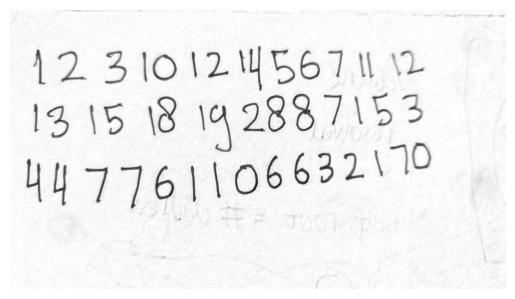

In [30]:
showPicture(img2.backup, True)

# Invert Image and Save Result

In [31]:
start_time = time()
img2.invertColor(thresh)
end_time = time()
print((end_time - start_time) * 1000, "ms")

4726.186275482178 ms


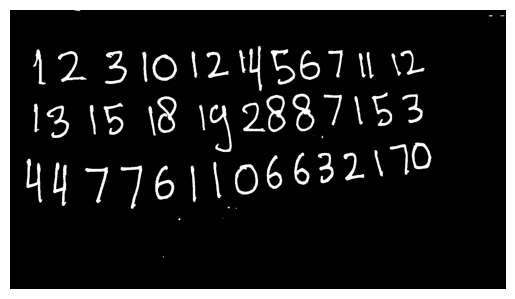

In [32]:
showPicture(img2.pixels, True)

In [34]:
# save result in root/out
path = abspath("../../out/{}/frame_out.png").format(FILENAME)
img_new = PIL.Image.fromarray(img2.pixels, mode="L")
img_new.save(path, mode="L")

In [37]:
# run this to restart images to last state
# img2.restart()

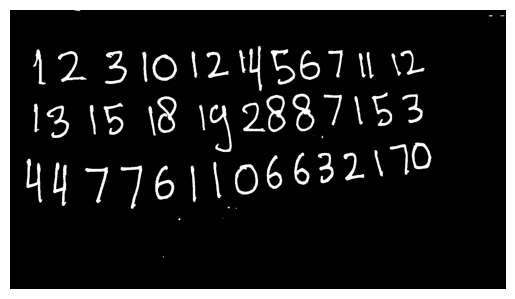

In [38]:
showPicture(img2.pixels, True)

# Bounding Box
Bounding box is the the smallest rectangles that encapsulate an object (for our case is a number)
To find bounding box, first find all connected pixels, then from connected pixels store the minP and maxP. Then from there, we can construct the bounding box

Algorithm Complexity is:
Time : $O(NM * log(N_{object}))$
Space : $O(min(N, M) + N_{object})$

In [83]:
start_time = time()
bbox_pipeline(img2.pixels)
end_time = time()
print((end_time - start_time) * 1000, "ms")

640.190839767456 ms


In [84]:
bbox = BoundingBox(img2.pixels)

In [85]:
start_time = time()
bbox.find()
end_time = time()
print((end_time - start_time) * 1000, "ms")

2608.123779296875 ms


In [74]:
bbox.viewBbox()
showPicture(bbox.result, False)

AttributeError: 'BoundingBox' object has no attribute '_BoundingBox__createBoudingBox'

In [75]:
# save result in root/out
path = abspath("../../out/{}/frame_out_bbox.png").format(FILENAME)
img_new = PIL.Image.fromarray(bbox.result, mode="L")
img_new.save(path, mode="L")

# Get Detected Shape
Get detected shape from bbox then scale the the image
resolution of the image must be 28 x 28 pixels

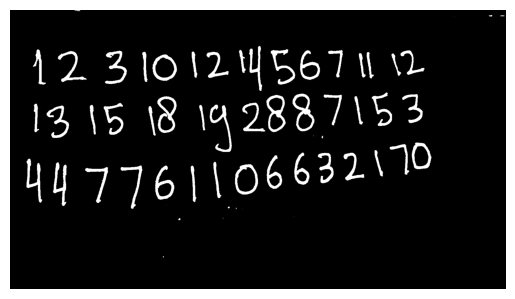

In [76]:
showPicture(img2.pixels, False)

In [77]:
s = bbox.getObjects()
print(s)

[[[4, 222], [6, 241]], [[21, 1647], [25, 1658]], [[22, 1686], [24, 1700]], [[24, 1527], [24, 1527]], [[127, 822], [280, 866]], [[138, 79], [258, 122]], [[138, 897], [258, 980]], [[140, 788], [218, 810]], [[141, 998], [242, 1065]], [[141, 1094], [234, 1144]], [[142, 1343], [225, 1425]], [[143, 326], [256, 401]], [[144, 165], [249, 263]], [[146, 625], [235, 643]], [[147, 455], [249, 472]], [[147, 676], [235, 751]], [[147, 1227], [237, 1251]], [[151, 1200], [234, 1223]], [[152, 1312], [229, 1345]], [[155, 490], [245, 573]], [[286, 1244], [400, 1313]], [[290, 972], [419, 1046]], [[292, 1349], [390, 1419]], [[293, 1079], [398, 1141]], [[294, 882], [421, 947]], [[299, 507], [424, 572]], [[299, 1185], [395, 1213]], [[321, 799], [419, 877]], [[322, 322], [430, 389]], [[325, 82], [422, 99]], [[328, 687], [489, 762]], [[329, 274], [429, 294]], [[329, 651], [415, 671]], [[331, 126], [441, 202]], [[333, 476], [433, 500]], [[434, 1043], [435, 1044]], [[434, 1072], [443, 1076]], [[458, 1382], [548, 

In [47]:
s = sortObjs(s)

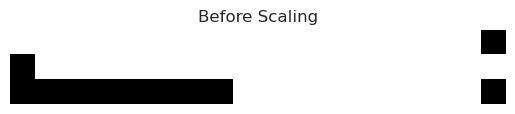

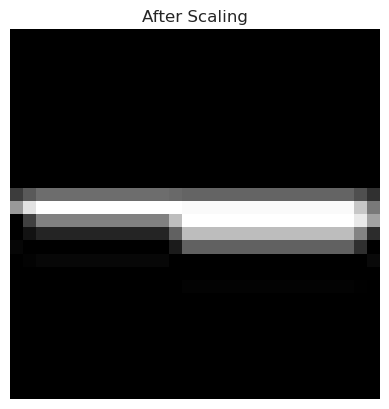

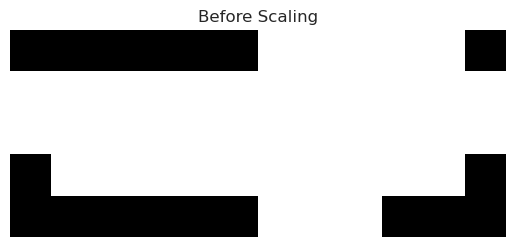

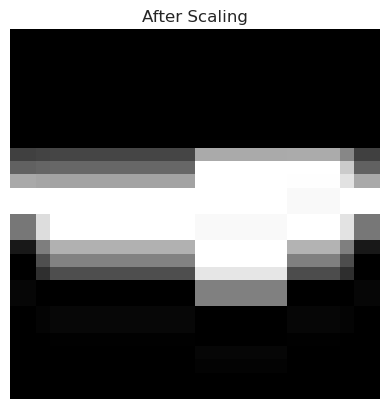

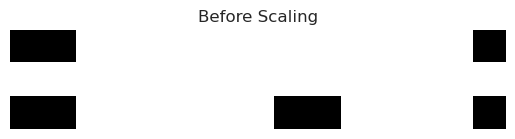

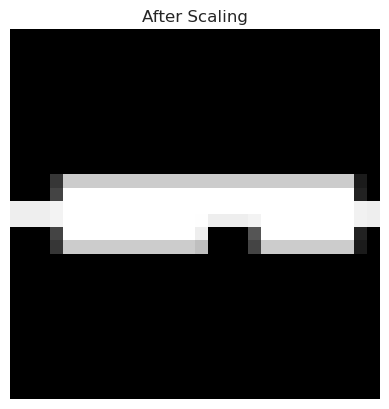

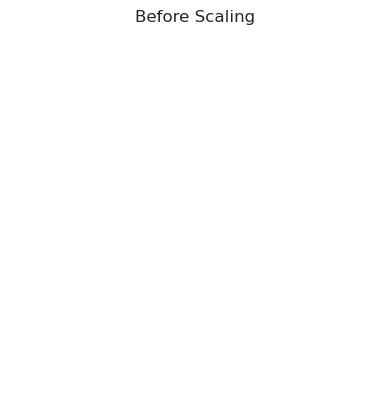

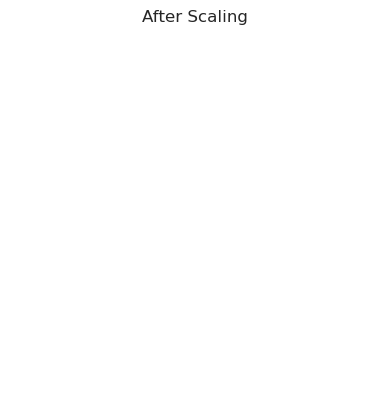

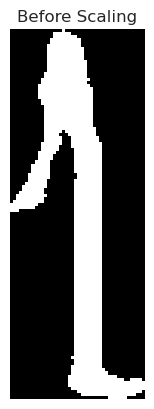

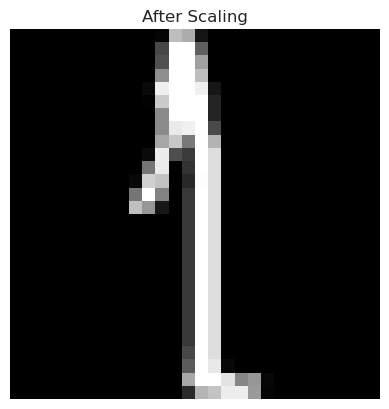

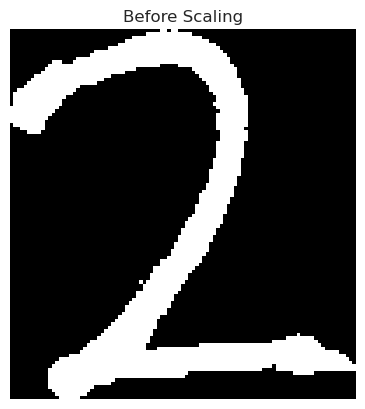

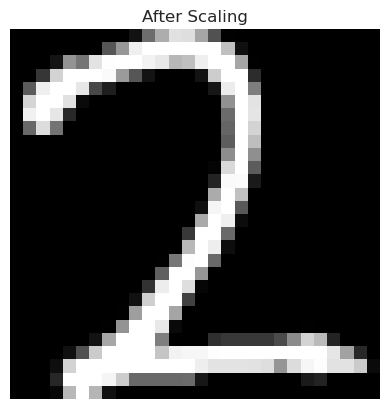

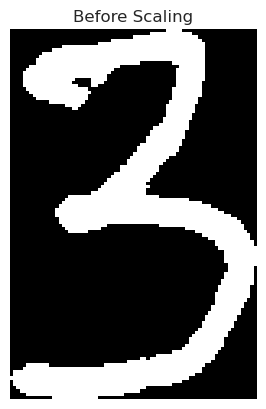

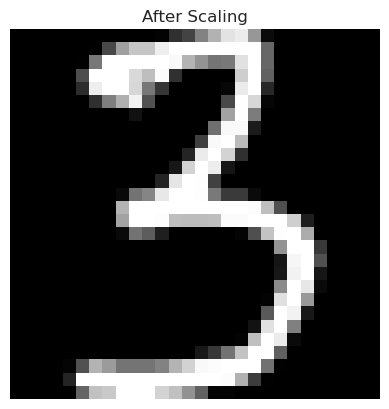

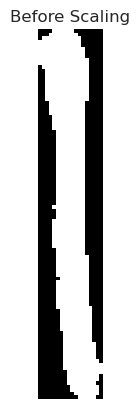

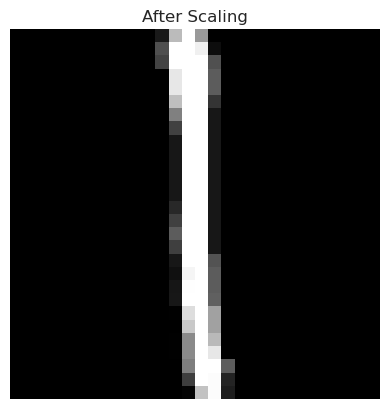

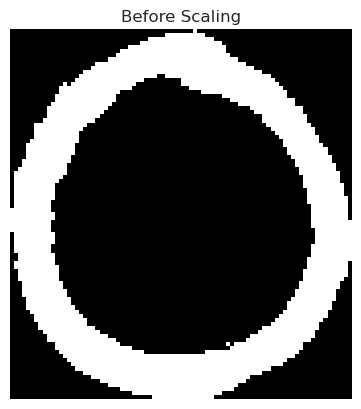

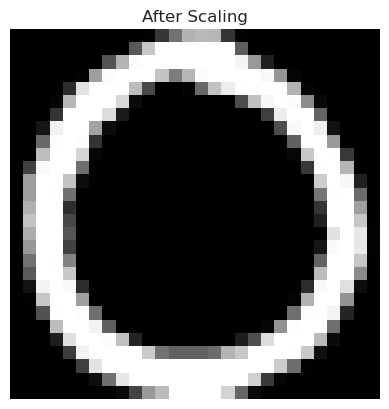

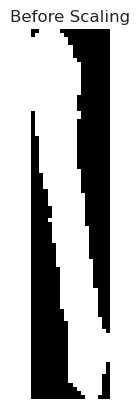

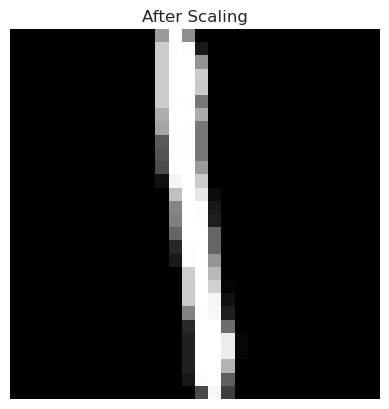

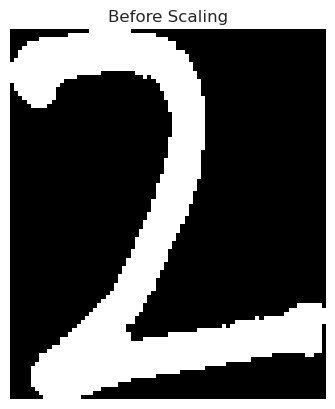

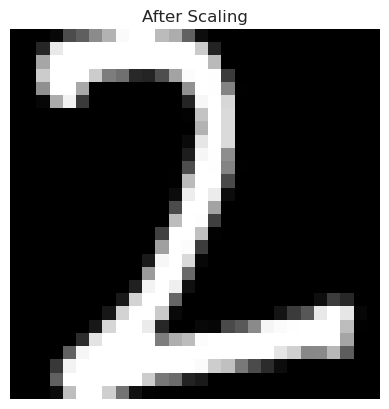

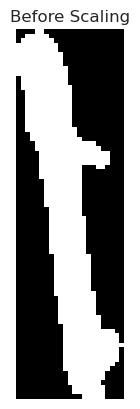

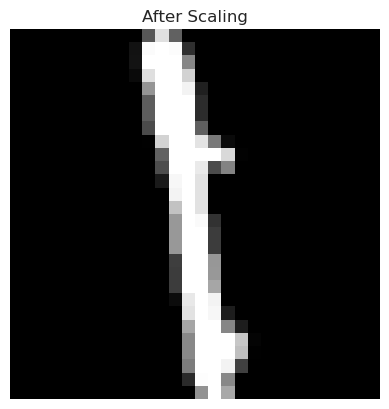

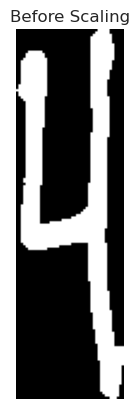

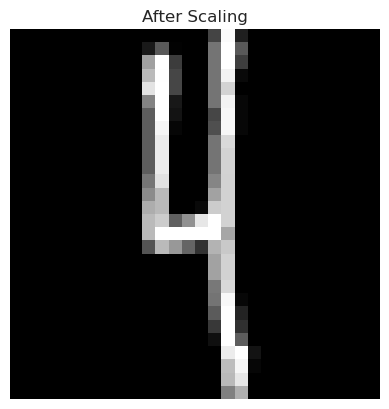

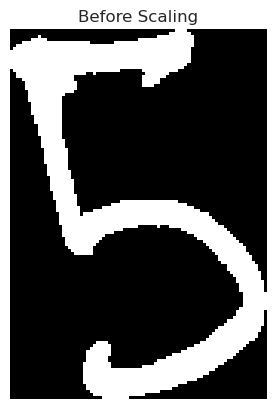

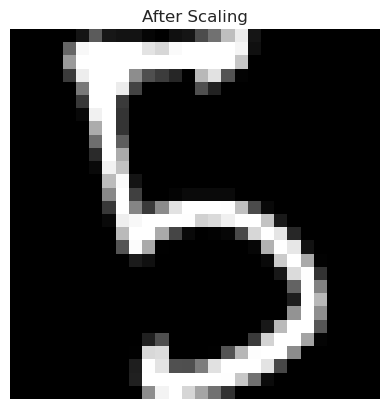

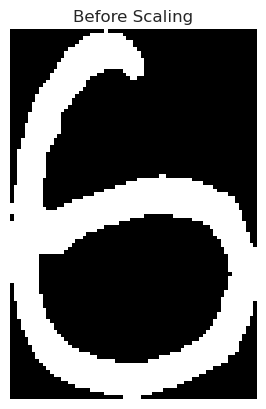

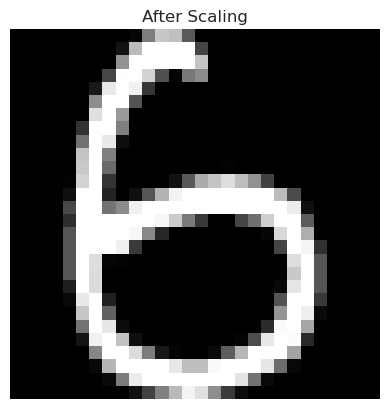

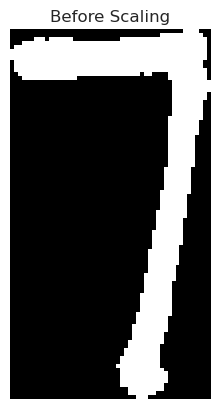

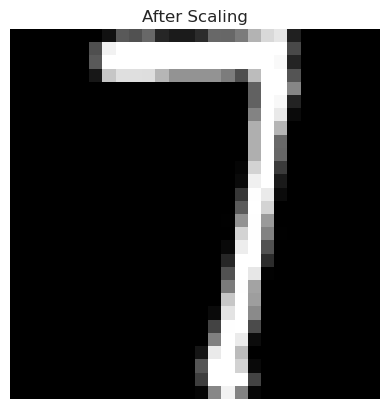

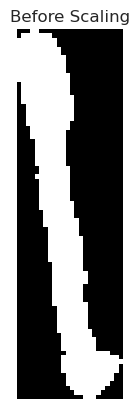

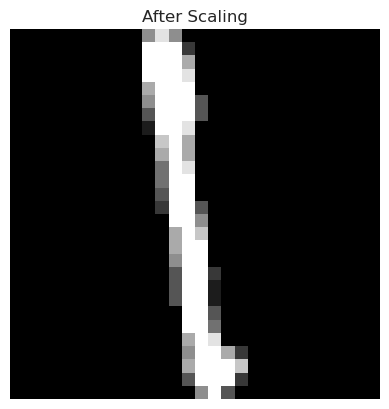

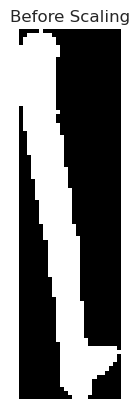

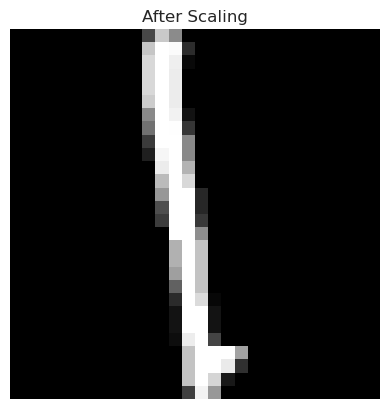

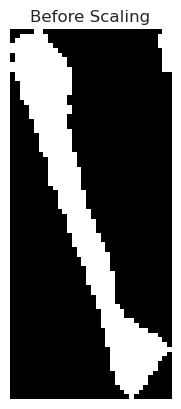

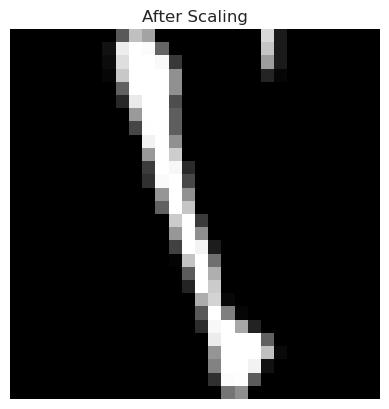

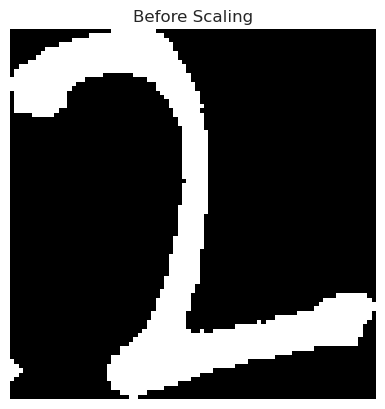

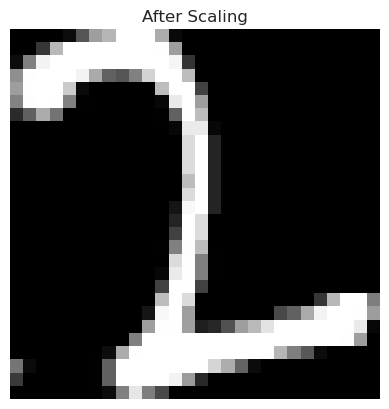

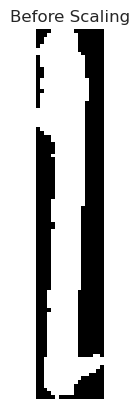

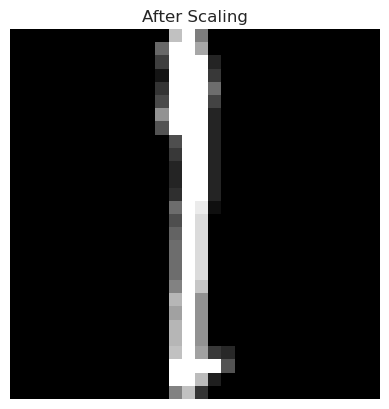

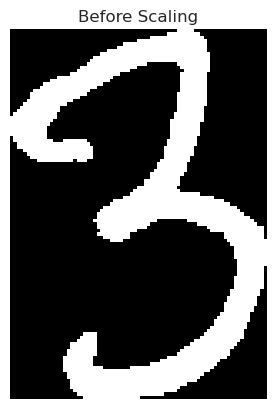

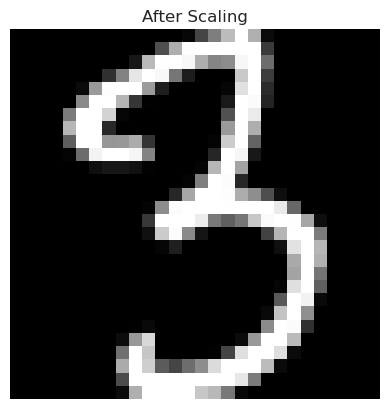

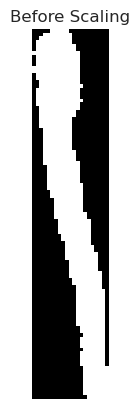

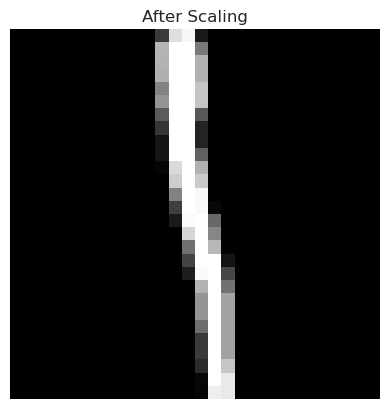

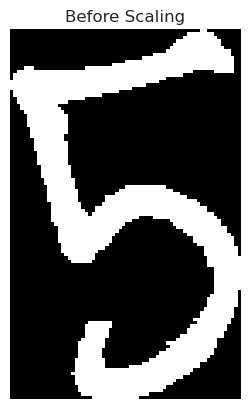

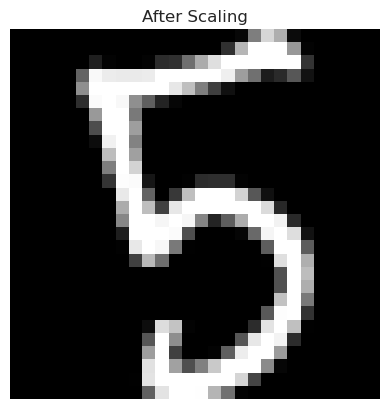

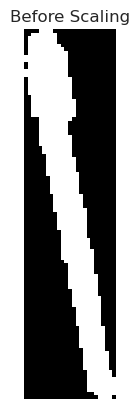

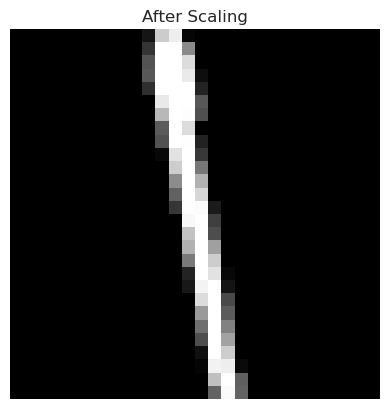

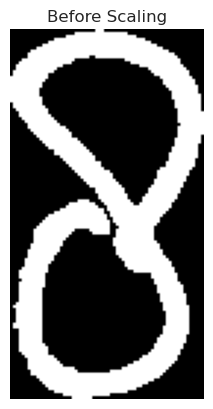

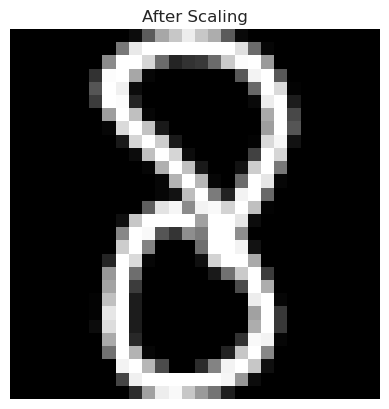

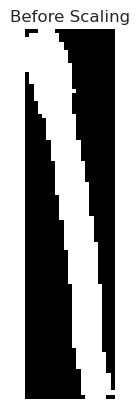

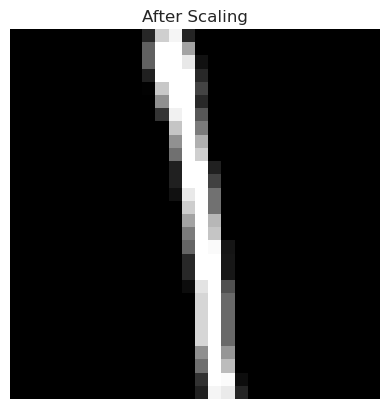

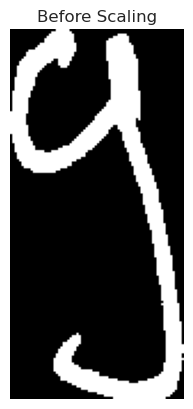

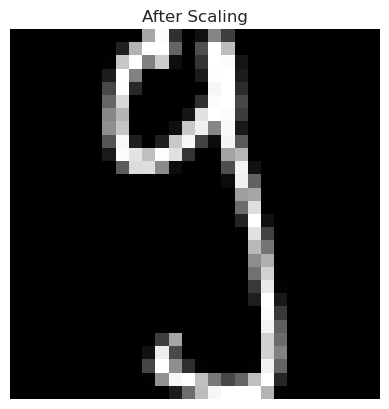

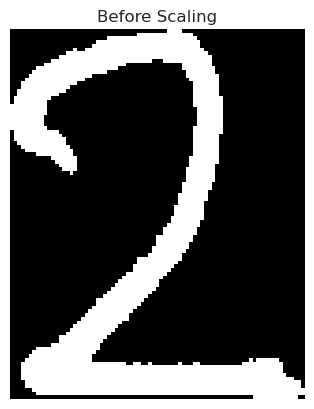

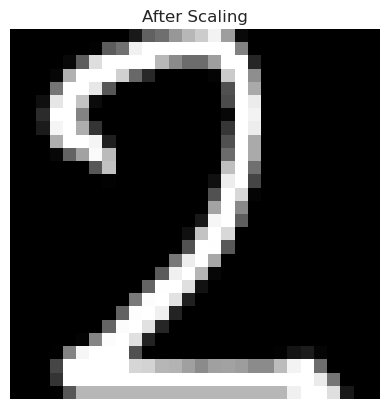

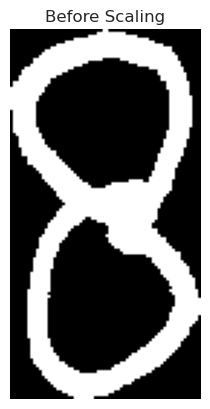

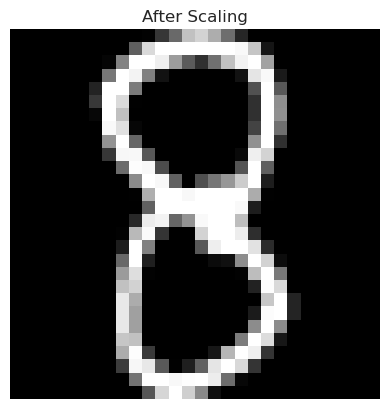

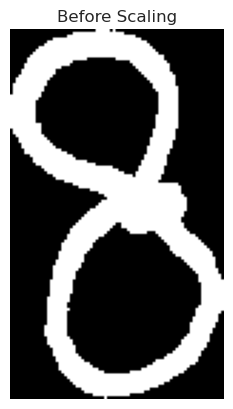

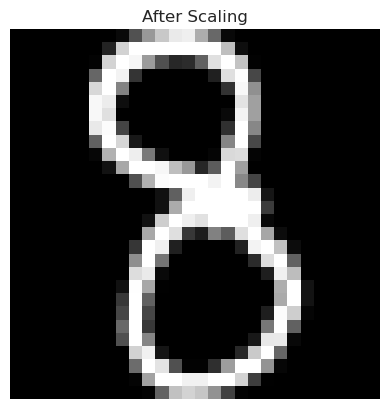

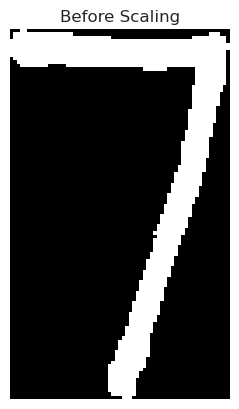

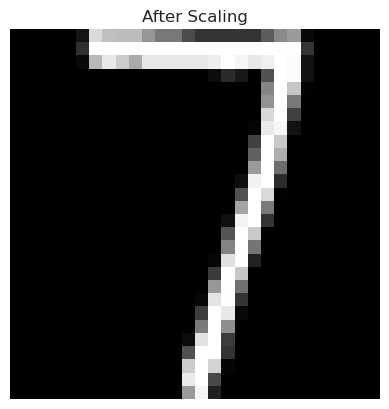

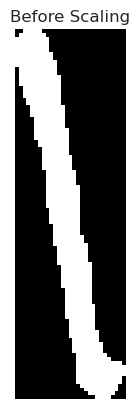

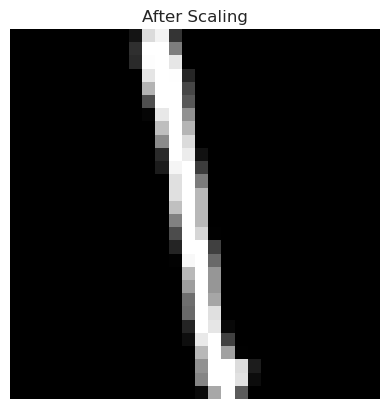

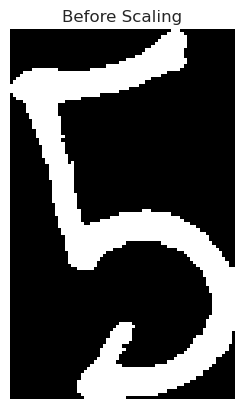

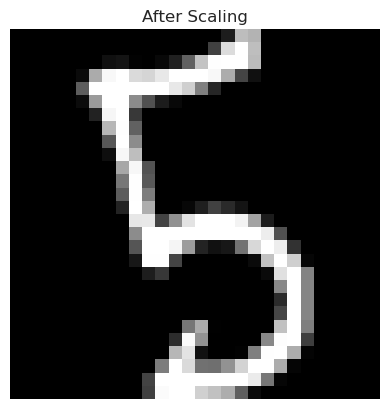

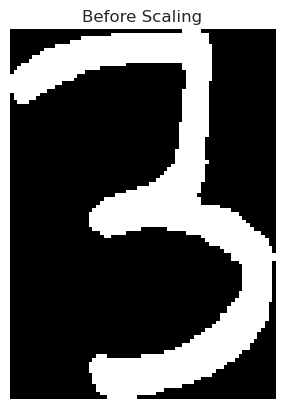

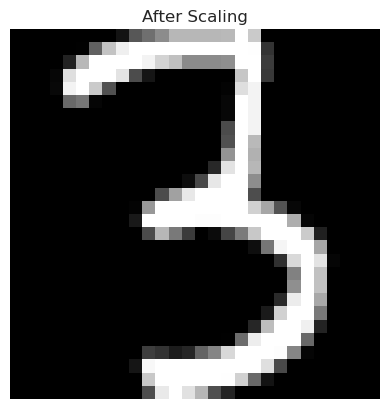

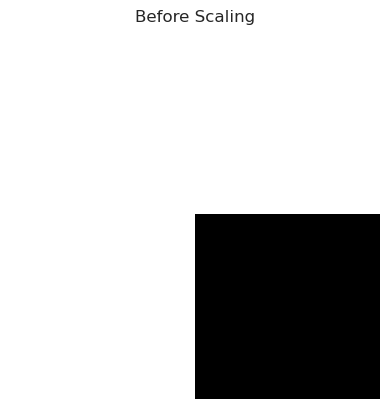

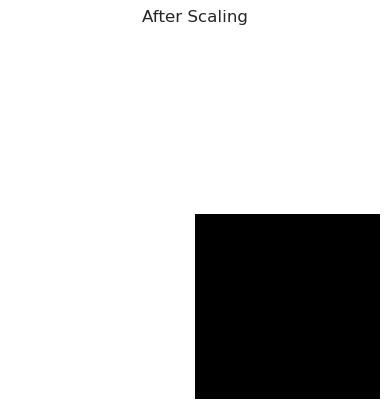

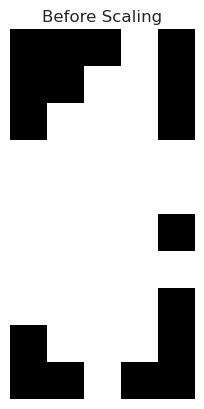

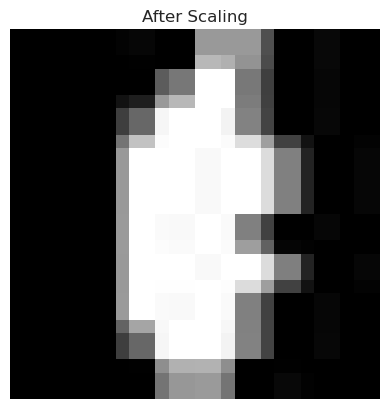

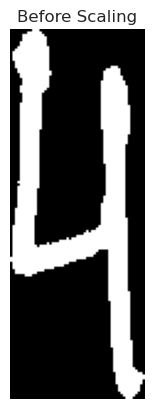

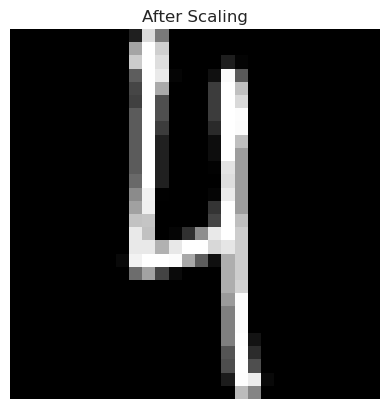

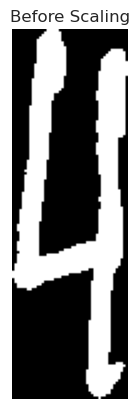

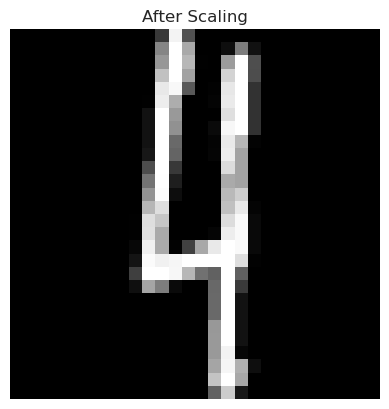

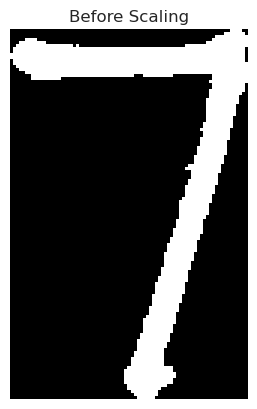

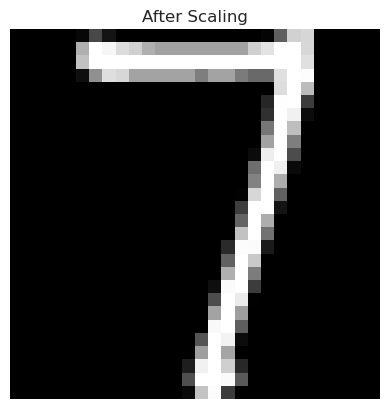

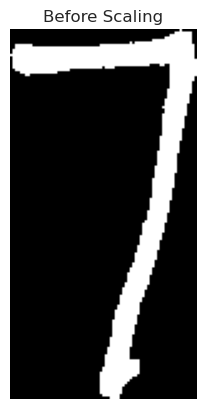

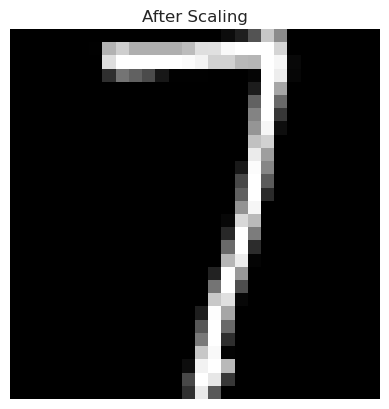

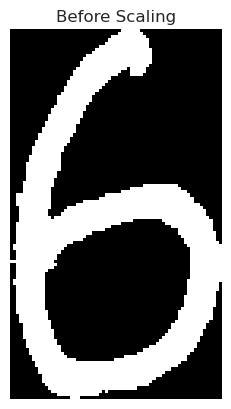

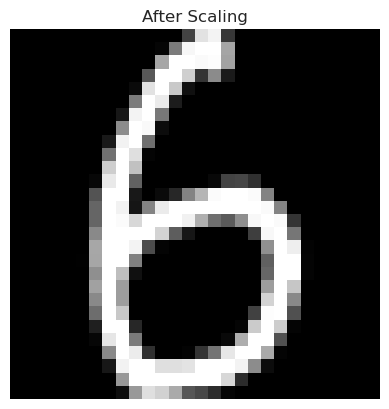

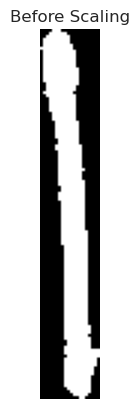

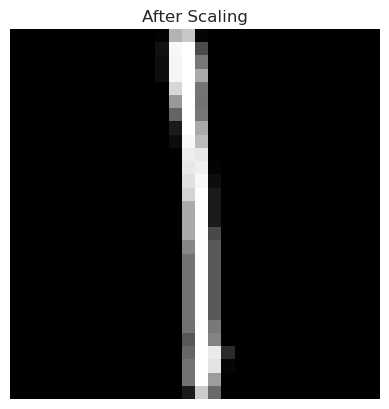

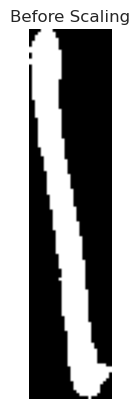

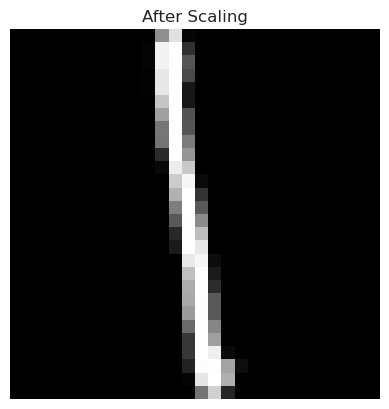

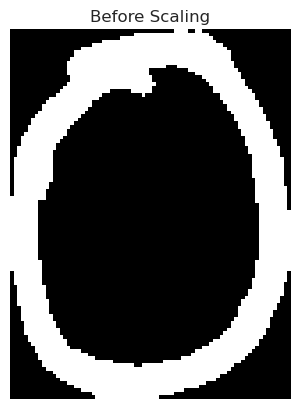

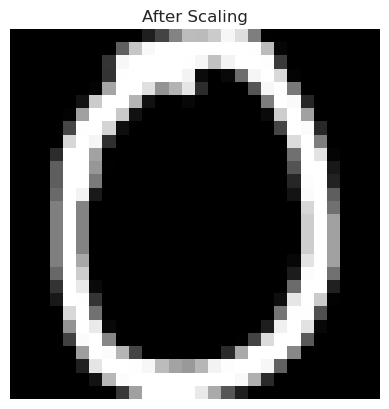

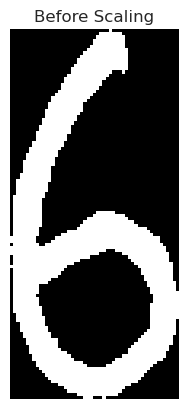

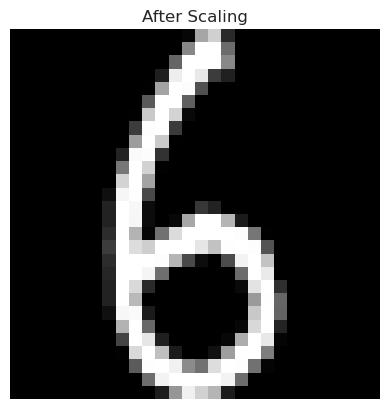

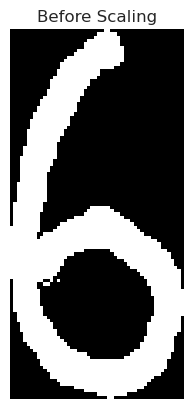

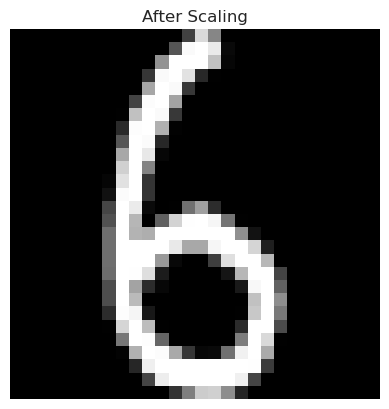

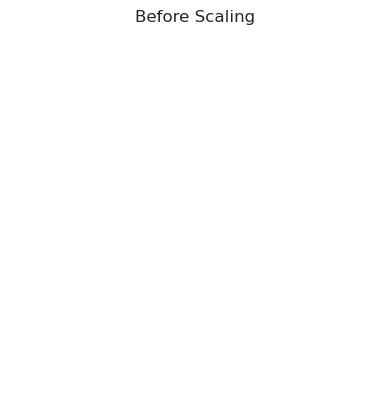

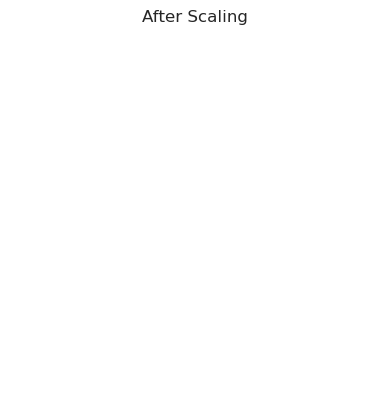

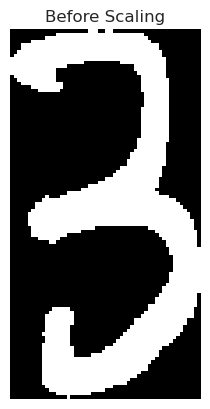

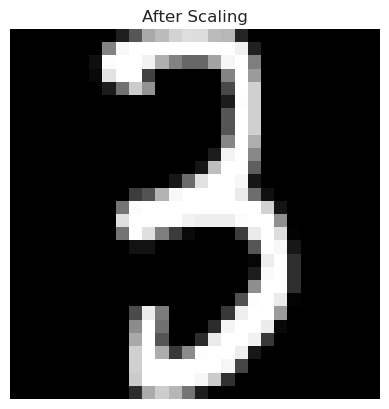

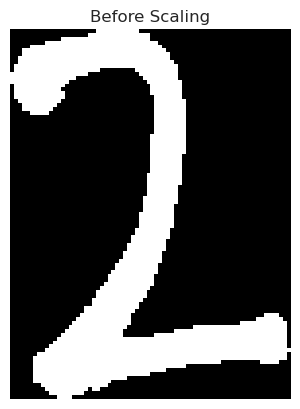

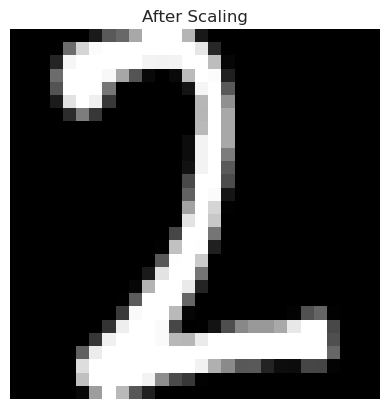

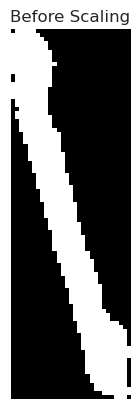

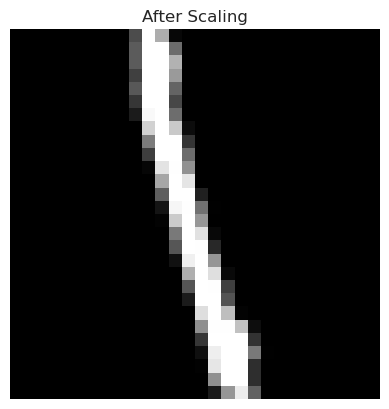

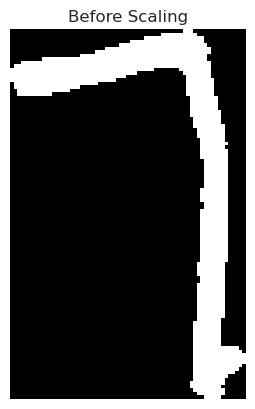

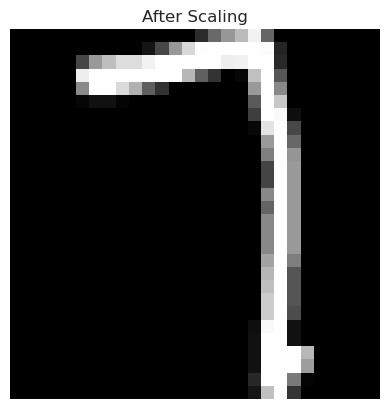

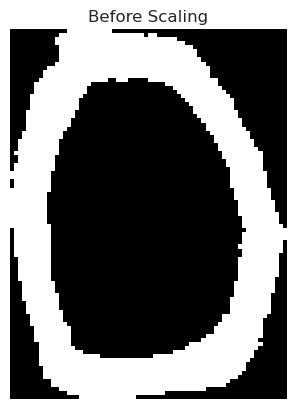

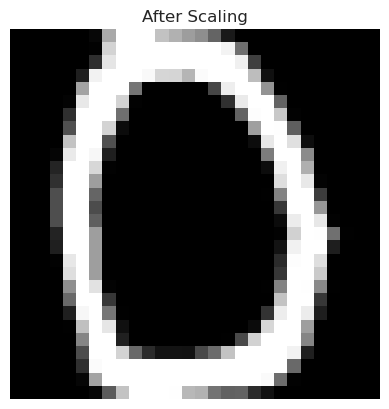

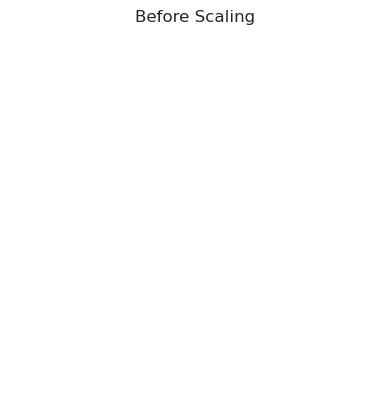

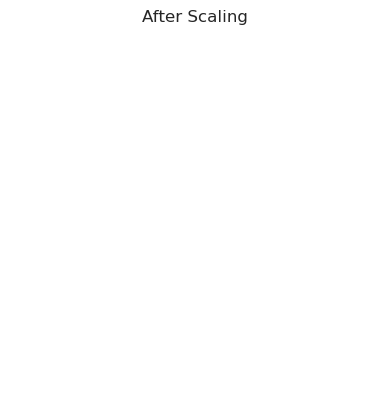

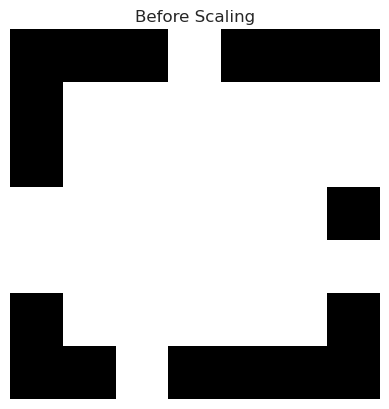

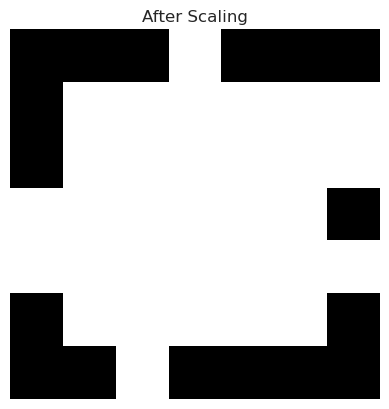

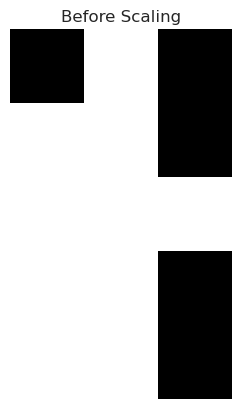

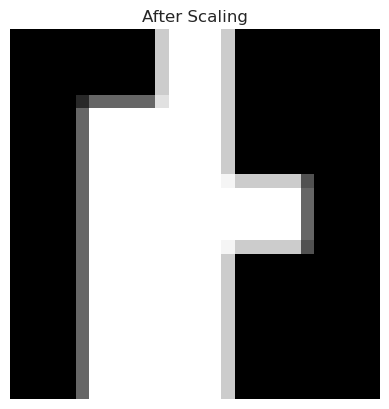

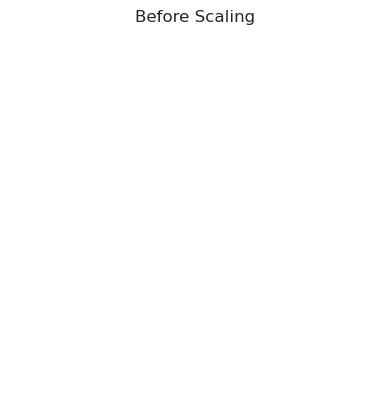

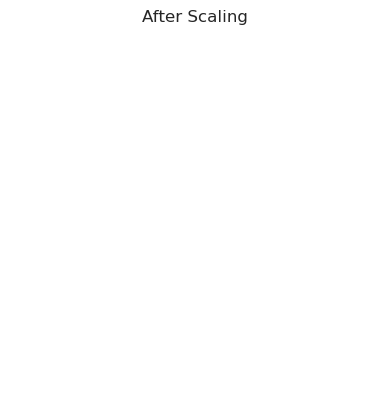

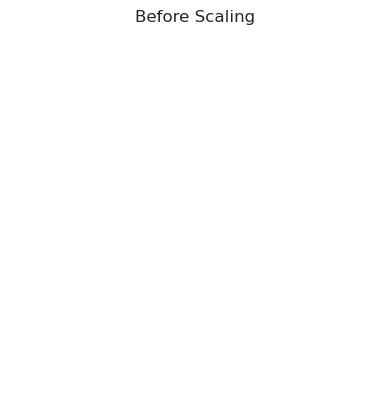

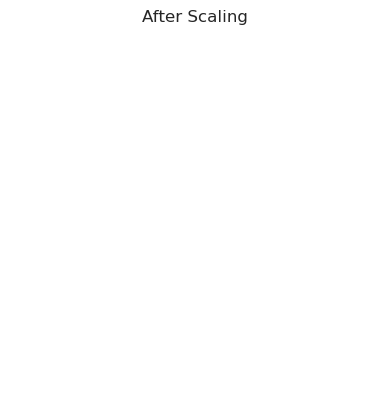

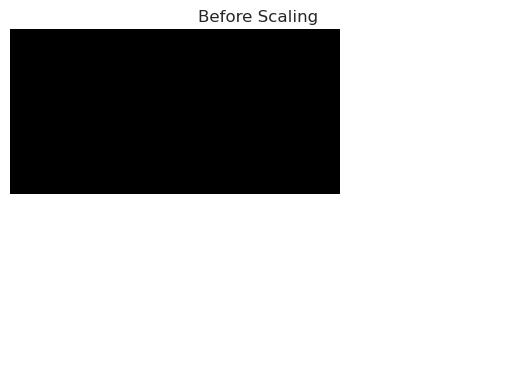

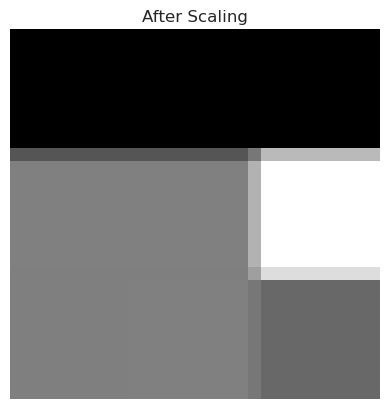

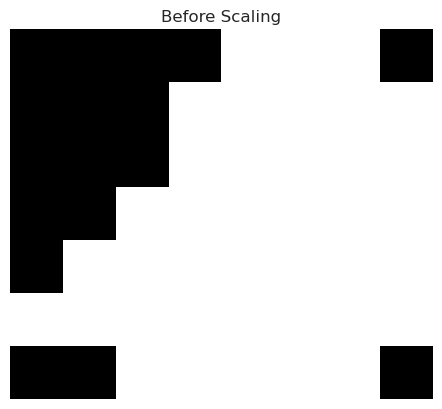

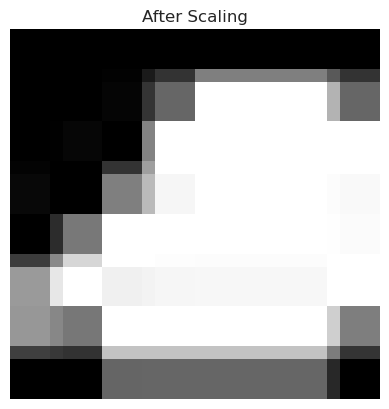

In [48]:
for obj in s:
    shape = getShape(img2.pixels, obj, show=True)

# Output

In [49]:
numbers = []
for obj in s:
    shape = getShape(img2.pixels, obj)
    numbers.append(shape)

Numbers adalah list dari gambar objek(Angka) yang dideteksi oleh sistem. Gambar direpresentasikan dengan array of pixels. 

# References
[1]. https://stackoverflow.com/questions/4150171/how-to-create-a-density-plot-in-matplotlib </br>
[2]. https://www.geeksforgeeks.org/erosion-dilation-images-using-opencv-python/ </br>
[3]. https://medium.com/arnekt-ai/shadow-removal-with-open-cv-71e030eadaf5